##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Spatial Attribution -- Building Blocks of Interpretability

This colab notebook is part of our **Building Blocks of Intepretability** series exploring how intepretability techniques combine together to explain neural networks. If you haven't already, make sure to look at the [**corresponding paper**](https://distill.pub/2018/building-blocks) as well!

This notebook demonstrates **Spatial Attribution**, a technique for exploring how detectors a different spatial positions in the network effected its output.

<br>

<img src="https://storage.googleapis.com/lucid-static/building-blocks/notebook_heroes/spatial-attribution.jpeg" width="648"></img>

<br>

This tutorial is based on [**Lucid**](https://github.com/tensorflow/lucid), a network for visualizing neural networks. Lucid is a kind of spiritual successor to DeepDream, but provides flexible abstractions so that it can be used for a wide range of interpretability research.

**Note**: The easiest way to use this tutorial is [as a colab notebook](), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

Thanks for trying Lucid!


# Install / Import / Load

This code depends on [Lucid](https://github.com/tensorflow/lucid) (our visualization library), and [svelte](https://svelte.technology/) (a web framework). The following cell will install both of them, and dependancies such as TensorFlow. And then import them as appropriate.

In [ ]:
!pip install --quiet "lucid>=0.3.11"
#!pip install --quiet --upgrade-strategy=only-if-needed git+https://github.com/tensorflow/lucid.git

In [10]:
import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.reading import read
from lucid.misc.io.showing import _image_url
from lucid.misc.gradient_override import gradient_override_map
import lucid.scratch.web.svelte as lucid_svelte

# Attribution Code

In [11]:
model = models.InceptionV1()
model.load_graphdef()

In [12]:
labels_str = read("https://gist.githubusercontent.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57/raw/aa66dd9dbf6b56649fa3fab83659b2acbf3cbfd1/map_clsloc.txt")
labels_str = labels_str.decode("utf-8")
labels = [line[line.find(" "):].strip() for line in labels_str.split("\n")]
labels = [label[label.find(" "):].strip().replace("_", " ") for label in labels]
labels = ["dummy"] + labels

In [13]:
def raw_class_spatial_attr(img, layer, label, override=None):
    """How much did spatial positions at a given layer effect a output class?"""

    # Set up a graph for doing attribution...
    with tf.Graph().as_default(), tf.compat.v1.Session(), gradient_override_map(override or {}):
        t_input = tf.compat.v1.placeholder_with_default(img, [None, None, 3])
        T = render.import_model(model, t_input, t_input)

        # Compute activations
        acts = T(layer).eval()

        if label is None: return np.zeros(acts.shape[1:-1])

        # Compute gradient
        score = T("softmax2_pre_activation")[0, labels.index(label)]
        t_grad = tf.gradients([score], [T(layer)])[0]   
        grad = t_grad.eval({T(layer) : acts})

        # Linear approximation of effect of spatial position
        return np.sum(acts * grad, -1)[0]

In [19]:
def raw_spatial_spatial_attr(img, layer1, layer2, override=None):
    """Attribution between spatial positions in two different layers."""

    # Set up a graph for doing attribution...
    with tf.Graph().as_default(), tf.compat.v1.Session(), gradient_override_map(override or {}):
        t_input = tf.compat.v1.placeholder_with_default(img, [None, None, 3])
        T = render.import_model(model, t_input, t_input)

        # Compute activations
        acts1 = T(layer1).eval()
        acts2 = T(layer2).eval({T(layer1) : acts1})

        # Construct gradient tensor
        # Backprop from spatial position (n_x, n_y) in layer2 to layer1.
        n_x, n_y = tf.compat.v1.placeholder("int32", []), tf.compat.v1.placeholder("int32", [])
        layer2_mags = tf.sqrt(tf.reduce_sum(T(layer2)**2, -1))[0]
        score = layer2_mags[n_x, n_y]
        t_grad = tf.gradients([score], [T(layer1)])[0]

        # Compute attribution backwards from each positin in layer2
        attrs = []
        for i in range(acts2.shape[1]):
            attrs_ = []
            for j in range(acts2.shape[2]):
                grad = t_grad.eval({n_x : i, n_y : j, T(layer1) : acts1})
                # linear approximation of imapct
                attr = np.sum(acts1 * grad, -1)[0]
                attrs_.append(attr)
            attrs.append(attrs_)
    return np.asarray(attrs)

In [20]:
def orange_blue(a,b,clip=False):
    if clip:
        a,b = np.maximum(a,0), np.maximum(b,0)
    arr = np.stack([a, (a + b)/2., b], -1)
    arr /= 1e-2 + np.abs(arr).max()/1.5
    arr += 0.3
    return arr

# Spatial Attribution Interface

In this section, we build the *interface* for interacting with the different kinds of spatial attribution data that we can compute using the above functions. Feel free to skip over this if you aren't interested in that part. The main reason we're including it is so that you can change the interface if you want to.


In [16]:
%%html_define_svelte SpatialWidget

<div class="figure" style="width: 500px; height: 250px; contain: strict;">
  <div class="outer" on:mouseleave="set({pos2: undefined})">
    <img class="img"  src="{{img}}">
    <img class="attr" src="{{(pos1 == undefined)? hint1 : spritemap1[pos1[1]][pos1[0]]}}">

    <svg class="pointer_container" viewBox="0 0 {{size1}} {{size1}}">
      {{#each xs1 as x}}
      {{#each ys1 as y}}
        <rect x={{x}} y={{y}} width=1 height=1
          class={{(pos2 != undefined && x == pos2[0] && y == pos2[1])? "selected" : ""}}
          on:mouseover="set({pos2: [x,y], pos1: undefined})"></rect>
      {{/each}}
      {{/each}}
    </svg> 

    <div class="label">{{layer1}}</div>
  </div>

  <div class="outer" on:mouseleave="set({pos1: undefined})">
    <img class="img" src="{{img}}">
    <img class="attr" src="{{(pos2 == undefined)? hint2 : spritemap2[pos2[1]][pos2[0]]}}">

    <svg class="pointer_container" viewBox="0 0 {{size2}} {{size2}}">
      {{#each xs2 as x}}
      {{#each ys2 as y}}
        <rect x={{x}} y={{y}} width=1 height=1
          class={{(pos1 != undefined && x == pos1[0] && y == pos1[1])? "selected" : ""}}
          on:mouseover="set({pos1: [x,y], pos2: undefined})"></rect>
      {{/each}}
      {{/each}}
    </svg> 

    <div class="label">{{layer2}}</div>
  </div>
  
</div>


<style>

  .outer{
    width: 224px;
    height: 224px;
    display: inline-block;
    margin-right: 2px;
    position: relative;
  }
  .outer img, .outer svg {
    position: absolute;
    left: 0px;
    top: 0px;
    width: 224px;
    height: 224px;
    image-rendering: pixelated; 
  }
  .attr {
    opacity: 0.6;
  }
  .pointer_container {
    z-index: 100;
  }
  .pointer_container rect {
    opacity: 0;
  }
  .pointer_container .selected  {
    opacity: 1;
    fill: none;
    stroke: hsl(24, 100%, 50%);
    stroke-width: 0.1px;
  }
  .label{
    position: absolute;
    left: 0px;
    top: 226px;
    width: 224px;
  }
</style>

<script>
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        img: "",
        hint1: "",
        hint2: "",
        spritemap1 : "",
        size1: 1,
        spritemap2 : "",
        size2: 1,
        pos1: undefined,
        pos2: undefined,
        layer1: "",
        layer2: ""
      };
    },
    computed: {
      xs1: (size1) => range(size1),
      ys1: (size1) => range(size1),
      xs2: (size2) => range(size2),
      ys2: (size2) => range(size2)
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /var/folders/99/xnsk42fs7sx6d3v5359sgstw0000gn/T/svelte_3z9disft/SpatialWidget_91a2d513_d0c0_475d_99dd_33fd1f16d7b1.html > /var/folders/99/xnsk42fs7sx6d3v5359sgstw0000gn/T/svelte_3z9disft/SpatialWidget_91a2d513_d0c0_475d_99dd_33fd1f16d7b1.js
b'svelte version 1.64.1\ncompiling ../../../../../../../var/folders/99/xnsk42fs7sx6d3v5359sgstw0000gn/T/svelte_3z9disft/SpatialWidget_91a2d513_d0c0_475d_99dd_33fd1f16d7b1.html...\n(4:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(5:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(21:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n(22:4) \xe2\x80\x93 A11y: <img> element should have an alt attribute\n'


In [17]:
def image_url_grid(grid):
    return [[_image_url(img) for img in line] for line in grid ]

def spatial_spatial_attr(img, layer1, layer2, hint_label_1=None, hint_label_2=None, override=None):

    hint1 = orange_blue(
        raw_class_spatial_attr(img, layer1, hint_label_1, override=override),
        raw_class_spatial_attr(img, layer1, hint_label_2, override=override),
        clip=True
    )
    hint2 = orange_blue(
        raw_class_spatial_attr(img, layer2, hint_label_1, override=override),
        raw_class_spatial_attr(img, layer2, hint_label_2, override=override),
        clip=True
    )

    attrs = raw_spatial_spatial_attr(img, layer1, layer2, override=override)
    attrs = attrs / attrs.max()

    lucid_svelte.SpatialWidget({
        "spritemap1": image_url_grid(attrs),
        "spritemap2": image_url_grid(attrs.transpose(2,3,0,1)),
        "size1": attrs.shape[3],
        "layer1": layer1,
        "size2": attrs.shape[0],
        "layer2": layer2,
        "img" : _image_url(img),
        "hint1": _image_url(hint1),
        "hint2": _image_url(hint2)
    })

# Simple Attribution Example


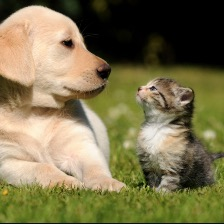


Hover on images to interact! :D



In [21]:
#img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")
img = load("https://github.com/ercaronte/lucid/raw/master/notebooks/static/dogcat.jpg")

spatial_spatial_attr(img, "mixed4d", "mixed5a", hint_label_1="Labrador retriever", hint_label_2="tiger cat")

print("\nHover on images to interact! :D\n")


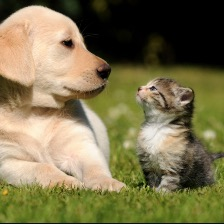


Hover on images to interact! :D



In [22]:
#img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")
img = load("https://github.com/ercaronte/lucid/raw/master/notebooks/static/dogcat.jpg")

spatial_spatial_attr(img, "mixed4a", "mixed4d", hint_label_1="Labrador retriever", hint_label_2="tiger cat")

print("\nHover on images to interact! :D\n")

# Attribution With GradPool override hack

In [23]:
def blur(x, w1, w2):
    """Spatially blur a 4D tensor."""
    x_ = tf.pad(x, [(0,0), (1,1), (1,1), (0,0)], "CONSTANT")
    x_jitter_hv = (x_[:, 2:, 1:-1] + x_[:, :-2, 1:-1] + x_[:, 1:-1, 2:] + x_[:, 1:-1, :-2])/4.
    x_jitter_diag = (x_[:, 2:, 2:] + x_[:, 2:, :-2] + x_[:, :-2, 2:] + x_[:, :-2, :-2])/4.
    return (1-w1-w2)*x + w1*x_jitter_hv + w2*x_jitter_diag

def make_MaxSmoothPoolGrad(blur_hack=False):
    """Create a relaxed version of the MaxPool gradient.
    
    GoogLeNet's use of MaxPooling creates a lot of gradient artifacts. This
    function creates a fake gradient that gets rid of them, reducing distractions
    in our UI demos.
    
    Be very very careful about using this in real life. It hides model behavior
    from you. This can help you see other things more clearly, but in most cases
    you probably should do something else.
    
    We're actively researching what's going on here.
    
    Args:
      blur_hack: If True, use the second less principled trick of slightly
        blurring the gradient to get rid of checkerboard artifacts.
    
    Returns:
      Gradient function.
      
    """
    def MaxPoolGrad(op, grad):
        inp = op.inputs[0]

        # Hack 1 (moderately principled): use a relaxation of the MaxPool grad
        # ---------------------------------------------------------------------
        #
        # Construct a pooling function where, if we backprop through it,
        # gradients get allocated proportional to the input activation.
        # Then backpropr through that instead.
        #
        # In some ways, this is kind of spiritually similar to SmoothGrad
        # (Smilkov et al.). To see the connection, note that MaxPooling introduces
        # a pretty arbitrary discontinuity to your gradient; with the right
        # distribution of input noise to the MaxPool op, you'd probably smooth out
        # to this. It seems like this is one of the most natural ways to smooth.
        #
        # We'll probably talk about this and related things in future work.

        op_args = [op.get_attr("ksize"), op.get_attr("strides"), op.get_attr("padding")]
        smooth_out = tf.nn.avg_pool(inp**2, *op_args)/ (1e-2+tf.nn.avg_pool(tf.abs(inp), *op_args))
        inp_smooth_grad = tf.gradients(smooth_out, [inp], grad)[0]

        # Hack 2 (if argument is set; not very principled) 
        # -------------------------------------------------
        #
        # Slightly blur gradient to get rid of checkerboard artifacts.
        # Note, this really isn't principled. We're working around / hiding a bad
        # property of the model. It should really be fixed by better model design.
        #
        # We do this so that the artifacts don't distract from the UI demo, but we
        # don't endorse people doing it in real applications.

        if blur_hack:
            inp_smooth_grad = blur(inp_smooth_grad, 0.5, 0.25)

        return inp_smooth_grad
    return MaxPoolGrad

In [24]:
def compare_attrs(img, layer1, layer2, hint_label_1, hint_label_2):
    print("Normal gradient:\n")

    spatial_spatial_attr(img, layer1, layer2,
                         hint_label_1=hint_label_1, hint_label_2=hint_label_2)

    print("\nSmooth MaxPool Grad:")
    print("(note the subtle checkerboard patterns)\n")

    spatial_spatial_attr(img, layer1, layer2,
                         hint_label_1=hint_label_1, hint_label_2=hint_label_2,
                         override={"MaxPool": make_MaxSmoothPoolGrad()})

    print("\nSmooth + Blur MaxPool Grad:\n")

    spatial_spatial_attr(img, layer1, layer2,
                         hint_label_1=hint_label_1, hint_label_2=hint_label_2,
                         override={"MaxPool": make_MaxSmoothPoolGrad(blur_hack=True)})

Normal gradient:




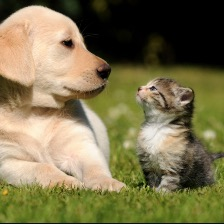


Smooth MaxPool Grad:
(note the subtle checkerboard patterns)




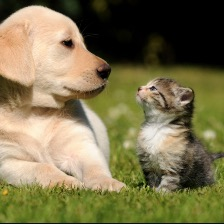


Smooth + Blur MaxPool Grad:




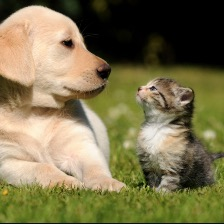

In [25]:
#img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")
img = load("https://github.com/ercaronte/lucid/raw/master/notebooks/static/dogcat.jpg")


compare_attrs(img, "mixed4d", "mixed5a", "Labrador retriever", "tiger cat")

Normal gradient:




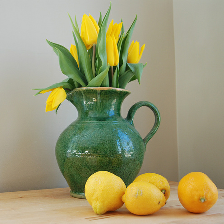


Smooth MaxPool Grad:
(note the subtle checkerboard patterns)




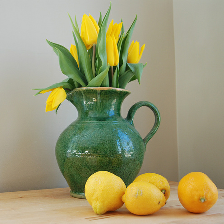


Smooth + Blur MaxPool Grad:




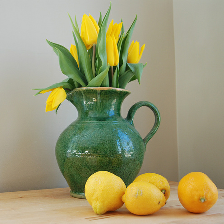

In [ ]:
img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/flowers.png")

compare_attrs(img, "mixed4d", "mixed5a", "lemon", "vase")